In [42]:
!pip install catboost -q

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# text processing
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

import catboost as cat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# misceallanous
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Overview

In [29]:
df = pd.read_csv("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")
df.head(3)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [30]:
df.shape

(5572, 2)

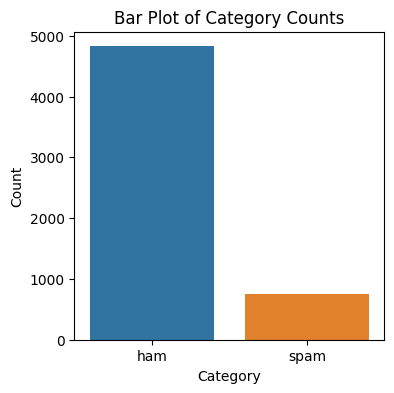

In [31]:
plt.figure(figsize=(4,4))
sns.barplot(x=df['Category'].value_counts().index, y=df['Category'].value_counts().values)
plt.xlabel('Category')
plt.ylabel('Count')  
plt.title('Bar Plot of Category Counts')
plt.show()

# Basic Preprocessing

## Label Mapping

In [32]:
def map_label(row):
    if row=='ham':
        return 0
    return 1

df['Category'] = df['Category'].apply(map_label)

## Tokenization

In [33]:
stop_words = set(stopwords.words('english'))

def tokenize_data(row):
    tokenized = word_tokenize(row)
    # exclude punctuation tokens and stopwords
    result = [w for w in tokenized if w.isalpha() and w not in stop_words]
    return result

df['tokenized_message'] = df['Message'].apply(tokenize_data)

## Stemming

In [34]:
ps = PorterStemmer()
def stem_data(row):
    stemmed_words = []
    for word in row:
        stemmed_words.append(ps.stem(word))
    return stemmed_words

df['stemmed_message'] = df['tokenized_message'].apply(stem_data)

## Cleaned Message
combine the stemming result into string

In [35]:
def cleaning_message(row):
    return " ".join(row)

df['cleaned_message'] = df['stemmed_message'].apply(cleaning_message)

In [36]:
df.head(3)

,Category,Message,tokenized_message,stemmed_message,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, Available, bugis, n, great...","[Go, jurong, point, avail, bugi, n, great, wor...",Go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, joke, wif, u, oni]",Ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, wkly, comp, win, FA, Cup, final,...","[free, entri, wkli, comp, win, FA, cup, final,...",free entri wkli comp win FA cup final tkt may ...


# Word Embeddings

## TF-IDF

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vector = tfidf_vectorizer.fit_transform(df['cleaned_message'])
tfidf_df = pd.DataFrame(tfidf_vector.toarray())

In [89]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5895,5896,5897,5898,5899,5900,5901,5902,5903,5904
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test Modelling with Catboost

In [45]:
# splitting data
X_train, X_val, y_train, y_val = train_test_split(tfidf_df, df['Category'], test_size=0.2, random_state=12)

# initiate catboost
cbc = cat.CatBoostClassifier(verbose=0)

# train
cbc.fit(X_train, y_train)

In [50]:
# evaluation
y_pred = cbc.predict(X_val)

print('confusion matrix')
print(confusion_matrix(y_val, y_pred))
print()
print('classification report')
print(classification_report(y_val, y_pred))

confusion matrix
[[955   2]
 [ 38 120]]

classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       957
           1       0.98      0.76      0.86       158

    accuracy                           0.96      1115
   macro avg       0.97      0.88      0.92      1115
weighted avg       0.96      0.96      0.96      1115



## Word2Vec

In [51]:
from gensim.models import Word2Vec
import gensim

### CBOW

In [77]:
# CBOW
cbow = Word2Vec(df['stemmed_message'], min_count=1, vector_size=50, window=3)
# embedded vectors
# df['cbow_vectors'] = df['stemmed_message'].apply(lambda x: [cbow.wv[word] for word in x])
df['cbow_vectors'] = df['stemmed_message'].apply(lambda x: np.mean([cbow.wv[word] for word in x], axis=0) if x else np.zeros(50))

In [88]:
df['cbow_vectors'].head()

0    [-0.05649581, 0.10082481, 0.02151195, 0.028802...
1    [-0.07580854, 0.102375306, 0.009520844, 0.0207...
2    [-0.06413532, 0.110081695, 0.03162008, 0.02231...
3    [-0.09562742, 0.16198719, 0.024975812, 0.03049...
4    [-0.06795818, 0.12169405, 0.024684293, 0.02793...
Name: cbow_vectors, dtype: object

### Test Model with Catboost

In [80]:
# splitting data
X_train, X_val, y_train, y_val = train_test_split(np.vstack(df['cbow_vectors']), df['Category'], test_size=0.2, random_state=12)

# initiate catboost
cbc = cat.CatBoostClassifier(verbose=0)

# train
cbc.fit(X_train, y_train)

In [81]:
# evaluation
y_pred = cbc.predict(X_val)

print('confusion matrix')
print(confusion_matrix(y_val, y_pred))
print()
print('classification report')
print(classification_report(y_val, y_pred))

confusion matrix
[[946  11]
 [ 43 115]]

classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       957
           1       0.91      0.73      0.81       158

    accuracy                           0.95      1115
   macro avg       0.93      0.86      0.89      1115
weighted avg       0.95      0.95      0.95      1115



### Skip Gram

In [83]:
# Skip Gram
skip_gram = Word2Vec(df['stemmed_message'], min_count=1, vector_size=50, window=3, sg=1)
# embedded vectors
# df['sg_vectors'] = df['stemmed_message'].apply(lambda x: [skip_gram.wv[word] for word in x])
df['sg_vectors'] = df['stemmed_message'].apply(lambda x: np.mean([skip_gram.wv[word] for word in x], axis=0) if x else np.zeros(50))

In [87]:
df['sg_vectors'].head()

0    [-0.0041305036, 0.01776124, 0.082262635, 0.113...
1    [0.0065742903, 0.007481229, 0.06646351, 0.1095...
2    [-0.09189574, -0.027206847, 0.18183601, 0.1464...
3    [0.027026907, 0.021056296, 0.067911856, 0.1090...
4    [0.00760528, 0.04481282, 0.054352295, 0.112737...
Name: sg_vectors, dtype: object

### Test Model with Catboost

In [85]:
# splitting data
X_train, X_val, y_train, y_val = train_test_split(np.vstack(df['sg_vectors']), df['Category'], test_size=0.2, random_state=12)

# initiate catboost
cbc = cat.CatBoostClassifier(verbose=0)

# train
cbc.fit(X_train, y_train)

In [86]:
# evaluation
y_pred = cbc.predict(X_val)

print('confusion matrix')
print(confusion_matrix(y_val, y_pred))
print()
print('classification report')
print(classification_report(y_val, y_pred))

confusion matrix
[[939  18]
 [ 29 129]]

classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       957
           1       0.88      0.82      0.85       158

    accuracy                           0.96      1115
   macro avg       0.92      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115



## Fasttext

In [90]:
from gensim.models import FastText
import gensim

In [98]:
ft = FastText(df['stemmed_message'], vector_size=128, min_count=3, window=5, sg=1, seed=12)

# check similar word
ft.wv.similar_by_word("good", topn=5)

[('love', 0.9942548274993896),
 ('have', 0.993563175201416),
 ('morn', 0.9911307096481323),
 ('hope', 0.9909753203392029),
 ('day', 0.9886800050735474)]

In [103]:
df['ft_vectors'] = df['stemmed_message'].apply(lambda x: np.mean([ft.wv[word] for word in x], axis=0) if x else np.zeros(128))
df['ft_vectors'].head()

0    [0.24358143, -0.043943312, -0.056582384, 0.254...
1    [0.24527003, -0.09375191, -0.079370506, 0.2498...
2    [0.26891515, 0.102682896, -0.06752705, 0.24642...
3    [0.25765884, -0.09662674, -0.09361839, 0.27285...
4    [0.2289463, -0.09165682, -0.019573372, 0.29342...
Name: ft_vectors, dtype: object

### Test Model with Catboost

In [104]:
# splitting data
X_train, X_val, y_train, y_val = train_test_split(np.vstack(df['ft_vectors']), df['Category'], test_size=0.2, random_state=12)

# initiate catboost
cbc = cat.CatBoostClassifier(verbose=0)

# train
cbc.fit(X_train, y_train)

In [105]:
# evaluation
y_pred = cbc.predict(X_val)

print('confusion matrix')
print(confusion_matrix(y_val, y_pred))
print()
print('classification report')
print(classification_report(y_val, y_pred))

confusion matrix
[[941  16]
 [ 24 134]]

classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       957
           1       0.89      0.85      0.87       158

    accuracy                           0.96      1115
   macro avg       0.93      0.92      0.92      1115
weighted avg       0.96      0.96      0.96      1115

